# TEST OF CATBOOST

Parameter tuning : https://catboost.ai/en/docs/concepts/parameter-tuning

Cat(egrocial)Boost -
Avantage : plus rapide que XG Boost car il ne nécessite pas le prétraitement de vos données
Ne pas utiliser de hot-encoding durant le preprocessing

## Très difficile à faire fonctionner aves sklearn pipeline, hors c'est l'objet qu'ont doit renvoyer....

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from catboost import CatBoostRegressor


In [2]:
data = pd.read_parquet('./data/train.parquet')
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,51.0,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.951244
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,1.0,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.693147
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,61.0,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.127134
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,44.0,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.806662


In [3]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"]) 

In [4]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [5]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
# Pour les années
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()[1:]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
year_encoder = StandardScaler()
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer([
    ('date', OneHotEncoder(handle_unknown="ignore"), date_cols),
    ('cat', categorical_encoder, categorical_cols),
    ('year', year_encoder, ['year'])
])

#preprocessor.fit_transform(X_train)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7fb0d47dd3a0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day', 'weekday',
                                                   'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('year', StandardScaler(),
                                                  ['year'])])),
                ('ridge', Ridge())])

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

print(f'Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}')
print(f'Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}')

Train set, RMSE=0.80
Test set, RMSE=0.73


## Example of mask

In [7]:
mask = ((X_test['counter_name'] == 'Totem 73 boulevard de Sébastopol S-N')
        & (X_test['date'] > pd.to_datetime('2021/09/01'))
        & (X_test['date'] < pd.to_datetime('2021/09/08')))

df_viz = X_test.loc[mask].copy()
df_viz['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz['bike_count (predicted)'] = np.exp(pipe.predict(X_test[mask])) -  1

Text(0, 0.5, 'bike_count')

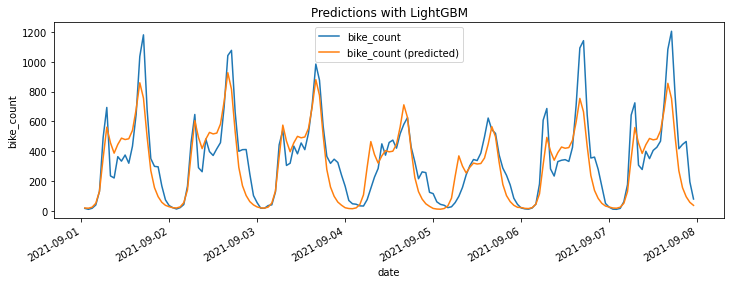

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (predicted)', ax=ax)
ax.set_title('Predictions with LightGBM')
ax.set_ylabel('bike_count')

In [7]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print('RMSE: ', scores)
print(f'RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}')

RMSE:  [-0.82872129 -1.01361234 -0.82012086 -1.08268358 -0.94019592 -1.4223016 ]
RMSE (all folds): 1.02 ± 0.204


## Using external data

In [8]:
df_ext = pd.read_csv(Path('submissions') / 'starting_kit' / 'external_data.csv')
df_ext.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


You can find the detailed documentation for each feature [in this PDF](https://donneespubliques.meteofrance.fr/client/document/doc_parametres_synop_168.pdf) (in French). Here the only feature we consider is the temperature. We will use [pandas.merge_asof](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.merge_asof.html) to merge on date, using the closest available date (since the sampling between the external data and the counter data).

In [15]:
# In this notebook we define the __file__ variable to be in the same conditions as when running the
# RAMP submission

__file__ = Path('submissions') /  'starting_kit' /  'estimator.py'


def _merge_external_data(X):
    file_path = Path(__file__).parent / 'external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date', 't', 'u', 'tend24', 'rr24']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X
    

In [16]:
X_train_merge = _merge_external_data(X_train)
columns_merge = X_train_merge.columns
X_train_merge

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,t,u,tend24,rr24
107,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,285.75,81,120.0,0.0
157,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,283.95,88,0.0,0.0
193,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,283.95,88,0.0,0.0
769,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,293.65,41,-260.0,0.0
959,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,292.15,47,-210.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
453515,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,293.05,53,940.0,0.2
453934,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,288.65,79,680.0,0.2
454316,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,287.15,88,590.0,0.2
454411,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,289.75,85,530.0,0.2


Similarly we can wrap this function into a FunctionTranformer to use it in a scikit-learn pipeline. Now let's see whether this additional feature improves the model,

In [41]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn_pandas import gen_features
from sklearn.feature_selection import SelectFromModel


# The issue is to indicate which data are categorical to combine Catboost and Sklearn pipeline

categorical_suffix = '_#CAT#'
categorical_cols = ["counter_name", "site_name"]

gen_category = gen_features(
    columns=categorical_cols,
    classes=[
        {
            "class": SimpleImputer,
            "strategy": "most_frequent"
        }
    ]
)

gen_category = [(col_name, transformer, {"alias": col_name[0] + categorical_suffix}) for col_name, transformer in gen_category]

### 

class CustomCatBoostRegressor(CatBoostRegressor):

    def fit(self, X, y=None, **fit_params):
        print(X.filter(regex=f"{categorical_suffix}$").columns.to_list())

        return super().fit(
            X,
            y=y,
            cat_features=X.filter(regex=f"{categorical_suffix}$").columns,
            **fit_params
        )

class CustomFeatureSelection(SelectFromModel):

    def transform(self, X):
        
        # Get indices of important features
        important_features_indices = list(self.get_support(indices=True))

        # Select important features
        _X = X.iloc[:, important_features_indices].copy()

        return _X

###

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

numeric_cols = ['t', 'u', 'tend24', 'rr24']

preprocessor = ColumnTransformer([
    # CatBoost doesn't requires OneHotEncoding, automatically (affect the training speed)
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(), categorical_cols),
    ('numeric', 'passthrough', numeric_cols)
])

regressor = CatBoostRegressor()

pipe =  make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor
)

In [ ]:
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', error_score=np.nan)
print(f'RMSE: {-scores.mean():.3} ± {(-scores).std():.3}')

## PARAMETERS TUNING

In [61]:
# Available params

model = CatBoostRegressor()
pipe.get_params()


{'memory': None,
 'steps': [('functiontransformer-1',
   FunctionTransformer(func=<function _merge_external_data at 0x7fb0be0e30d0>)),
  ('functiontransformer-2',
   FunctionTransformer(func=<function _encode_dates at 0x7fb0d47dd3a0>)),
  ('columntransformer',
   ColumnTransformer(transformers=[('date', 'passthrough',
                                    ['year', 'month', 'day', 'weekday', 'hour']),
                                   ('cat', OrdinalEncoder(),
                                    ['counter_name', 'site_name']),
                                   ('numeric', 'passthrough',
                                    ['t', 'u', 'tend24', 'rr24'])])),
  ('catboostregressor', <catboost.core.CatBoostRegressor at 0x7fb0bcd15280>)],
 'verbose': False,
 'functiontransformer-1': FunctionTransformer(func=<function _merge_external_data at 0x7fb0be0e30d0>),
 'functiontransformer-2': FunctionTransformer(func=<function _encode_dates at 0x7fb0d47dd3a0>),
 'columntransformer': ColumnTransformer(

In [71]:
# One hot max size
params = {
'catboostregressor__one_hot_max_size' : [0, 2, 10, 255]
}

In [72]:
from sklearn.model_selection import GridSearchCV

model_grid_search = GridSearchCV(pipe, param_grid=params, n_jobs=4, cv=4)
result_train = model_grid_search.fit(X_train, y_train)
result_test = model_grid_search.fit(X_test, y_test)

Learning rate set to 0.102903
Learning rate set to 0.102903
Learning rate set to 0.102903
Learning rate set to 0.102903
0:	learn: 1.5309425	total: 142ms	remaining: 2m 21s
0:	learn: 1.5784893	total: 221ms	remaining: 3m 40s
1:	learn: 1.4443252	total: 300ms	remaining: 2m 29s
0:	learn: 1.5826030	total: 227ms	remaining: 3m 46s
0:	learn: 1.5935584	total: 236ms	remaining: 3m 55s
1:	learn: 1.4868641	total: 358ms	remaining: 2m 58s
1:	learn: 1.4960469	total: 375ms	remaining: 3m 6s
2:	learn: 1.3706895	total: 463ms	remaining: 2m 33s
1:	learn: 1.5089321	total: 393ms	remaining: 3m 16s
2:	learn: 1.4083009	total: 522ms	remaining: 2m 53s
3:	learn: 1.3033587	total: 591ms	remaining: 2m 27s
2:	learn: 1.4216759	total: 518ms	remaining: 2m 52s
2:	learn: 1.4366365	total: 550ms	remaining: 3m 2s
4:	learn: 1.2454752	total: 671ms	remaining: 2m 13s
3:	learn: 1.3574596	total: 627ms	remaining: 2m 36s
3:	learn: 1.3388075	total: 646ms	remaining: 2m 40s
3:	learn: 1.3753123	total: 710ms	remaining: 2m 56s
4:	learn: 1.280

/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

996:	learn: 0.4224873	total: 2m 15s	remaining: 408ms
997:	learn: 0.4224333	total: 2m 15s	remaining: 272ms
998:	learn: 0.4223809	total: 2m 15s	remaining: 136ms
999:	learn: 0.4223142	total: 2m 16s	remaining: 0us


/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

Learning rate set to 0.102903
0:	learn: 1.5784893	total: 152ms	remaining: 2m 31s
1:	learn: 1.4868641	total: 287ms	remaining: 2m 23s
2:	learn: 1.4083009	total: 364ms	remaining: 2m
3:	learn: 1.3388075	total: 516ms	remaining: 2m 8s
4:	learn: 1.2802189	total: 654ms	remaining: 2m 10s
Learning rate set to 0.102903
Learning rate set to 0.102903
5:	learn: 1.2265547	total: 851ms	remaining: 2m 20s
6:	learn: 1.1807258	total: 996ms	remaining: 2m 21s
0:	learn: 1.5826030	total: 149ms	remaining: 2m 29s
0:	learn: 1.5935584	total: 202ms	remaining: 3m 22s
7:	learn: 1.1433669	total: 1.09s	remaining: 2m 14s
1:	learn: 1.4960469	total: 269ms	remaining: 2m 14s
Learning rate set to 0.102903
1:	learn: 1.5089321	total: 369ms	remaining: 3m 4s
8:	learn: 1.1087416	total: 1.26s	remaining: 2m 18s
2:	learn: 1.4216759	total: 434ms	remaining: 2m 24s
2:	learn: 1.4366365	total: 522ms	remaining: 2m 53s
9:	learn: 1.0782471	total: 1.36s	remaining: 2m 14s
3:	learn: 1.3574596	total: 573ms	remaining: 2m 22s
0:	learn: 1.5309425

/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

Learning rate set to 0.102903
Learning rate set to 0.102903
0:	learn: 1.5784893	total: 82.4ms	remaining: 1m 22s
0:	learn: 1.5935584	total: 98.4ms	remaining: 1m 38s
1:	learn: 1.4868641	total: 189ms	remaining: 1m 34s
1:	learn: 1.5089321	total: 237ms	remaining: 1m 58s
Learning rate set to 0.102903
2:	learn: 1.4083009	total: 404ms	remaining: 2m 14s
Learning rate set to 0.102903
2:	learn: 1.4366365	total: 417ms	remaining: 2m 18s
3:	learn: 1.3753123	total: 483ms	remaining: 2m
3:	learn: 1.3388075	total: 527ms	remaining: 2m 11s
0:	learn: 1.5826030	total: 141ms	remaining: 2m 20s
0:	learn: 1.5309425	total: 115ms	remaining: 1m 55s
4:	learn: 1.2802189	total: 630ms	remaining: 2m 5s
4:	learn: 1.3227644	total: 626ms	remaining: 2m 4s
1:	learn: 1.4960469	total: 268ms	remaining: 2m 13s
1:	learn: 1.4443252	total: 232ms	remaining: 1m 55s
5:	learn: 1.2265547	total: 753ms	remaining: 2m 4s
5:	learn: 1.2695564	total: 717ms	remaining: 1m 58s
2:	learn: 1.4216759	total: 382ms	remaining: 2m 7s
2:	learn: 1.3706895

/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

994:	learn: 0.4225719	total: 2m 50s	remaining: 859ms
997:	learn: 0.4111526	total: 2m 50s	remaining: 341ms
999:	learn: 0.4239526	total: 2m 50s	remaining: 0us
995:	learn: 0.4225169	total: 2m 51s	remaining: 687ms
998:	learn: 0.4110910	total: 2m 50s	remaining: 171ms
996:	learn: 0.4224873	total: 2m 51s	remaining: 515ms
999:	learn: 0.4109986	total: 2m 50s	remaining: 0us
997:	learn: 0.4224333	total: 2m 51s	remaining: 343ms
998:	learn: 0.4223809	total: 2m 51s	remaining: 172ms
999:	learn: 0.4223142	total: 2m 51s	remaining: 0us


/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

Learning rate set to 0.102903
0:	learn: 1.5784893	total: 69.2ms	remaining: 1m 9s
1:	learn: 1.4868641	total: 178ms	remaining: 1m 28s
2:	learn: 1.4083009	total: 259ms	remaining: 1m 25s
3:	learn: 1.3388075	total: 345ms	remaining: 1m 25s
4:	learn: 1.2802189	total: 416ms	remaining: 1m 22s
5:	learn: 1.2265547	total: 504ms	remaining: 1m 23s
6:	learn: 1.1807258	total: 574ms	remaining: 1m 21s
7:	learn: 1.1433669	total: 659ms	remaining: 1m 21s
Learning rate set to 0.102903
8:	learn: 1.1087416	total: 782ms	remaining: 1m 26s
9:	learn: 1.0782471	total: 868ms	remaining: 1m 25s
10:	learn: 1.0514602	total: 976ms	remaining: 1m 27s
0:	learn: 1.5935584	total: 141ms	remaining: 2m 21s
Learning rate set to 0.102903
11:	learn: 1.0289536	total: 1.12s	remaining: 1m 32s
1:	learn: 1.5089321	total: 293ms	remaining: 2m 26s
Learning rate set to 0.102903
12:	learn: 1.0092076	total: 1.26s	remaining: 1m 35s
0:	learn: 1.5826030	total: 131ms	remaining: 2m 10s
2:	learn: 1.4366365	total: 444ms	remaining: 2m 27s
13:	learn:

/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

990:	learn: 0.4212996	total: 2m 25s	remaining: 1.32s
988:	learn: 0.4116171	total: 2m 25s	remaining: 1.61s
991:	learn: 0.4212622	total: 2m 25s	remaining: 1.18s
989:	learn: 0.4115915	total: 2m 25s	remaining: 1.47s
990:	learn: 0.4115688	total: 2m 25s	remaining: 1.32s
992:	learn: 0.4212390	total: 2m 25s	remaining: 1.03s
991:	learn: 0.4114858	total: 2m 25s	remaining: 1.17s
993:	learn: 0.4211738	total: 2m 25s	remaining: 881ms
994:	learn: 0.4211375	total: 2m 26s	remaining: 734ms
992:	learn: 0.4114499	total: 2m 25s	remaining: 1.02s


/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

993:	learn: 0.4113913	total: 2m 25s	remaining: 879ms
995:	learn: 0.4210985	total: 2m 26s	remaining: 587ms
994:	learn: 0.4113490	total: 2m 25s	remaining: 732ms
996:	learn: 0.4210400	total: 2m 26s	remaining: 440ms
995:	learn: 0.4112987	total: 2m 25s	remaining: 585ms
997:	learn: 0.4209910	total: 2m 26s	remaining: 293ms
996:	learn: 0.4112441	total: 2m 25s	remaining: 439ms
998:	learn: 0.4209296	total: 2m 26s	remaining: 147ms
997:	learn: 0.4111526	total: 2m 25s	remaining: 292ms
999:	learn: 0.4209050	total: 2m 26s	remaining: 0us
998:	learn: 0.4110910	total: 2m 25s	remaining: 146ms
999:	learn: 0.4109986	total: 2m 26s	remaining: 0us


/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

Learning rate set to 0.107689
0:	learn: 1.5702108	total: 96.5ms	remaining: 1m 36s
1:	learn: 1.4796522	total: 146ms	remaining: 1m 12s
2:	learn: 1.4036678	total: 190ms	remaining: 1m 3s
3:	learn: 1.3381176	total: 223ms	remaining: 55.6s
4:	learn: 1.2825023	total: 254ms	remaining: 50.6s
5:	learn: 1.2335929	total: 290ms	remaining: 48s
6:	learn: 1.1918739	total: 327ms	remaining: 46.4s
7:	learn: 1.1584390	total: 357ms	remaining: 44.2s
8:	learn: 1.1286402	total: 389ms	remaining: 42.9s
9:	learn: 1.1038848	total: 423ms	remaining: 41.8s
10:	learn: 1.0832519	total: 451ms	remaining: 40.6s
11:	learn: 1.0650290	total: 486ms	remaining: 40s
12:	learn: 1.0482677	total: 515ms	remaining: 39.1s
13:	learn: 1.0301182	total: 545ms	remaining: 38.4s
14:	learn: 1.0174125	total: 579ms	remaining: 38s
15:	learn: 1.0063485	total: 609ms	remaining: 37.5s
16:	learn: 0.9926902	total: 641ms	remaining: 37.1s
17:	learn: 0.9838204	total: 677ms	remaining: 36.9s
18:	learn: 0.9749271	total: 705ms	remaining: 36.4s
19:	learn: 0.9

/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

Learning rate set to 0.070513
0:	learn: 1.3712460	total: 16.3ms	remaining: 16.3s
1:	learn: 1.3098624	total: 24.6ms	remaining: 12.3s
2:	learn: 1.2560158	total: 41.7ms	remaining: 13.9s
Learning rate set to 0.070513
3:	learn: 1.2031850	total: 49.5ms	remaining: 12.3s
4:	learn: 1.1554435	total: 70.2ms	remaining: 14s
0:	learn: 1.4003996	total: 27.6ms	remaining: 27.5s
5:	learn: 1.1139637	total: 83.6ms	remaining: 13.9s
1:	learn: 1.3462183	total: 40.1ms	remaining: 20s
6:	learn: 1.0764162	total: 95ms	remaining: 13.5s
7:	learn: 1.0394732	total: 103ms	remaining: 12.7s
8:	learn: 1.0066983	total: 114ms	remaining: 12.6s
9:	learn: 0.9760791	total: 130ms	remaining: 12.9s
2:	learn: 1.2985227	total: 83.6ms	remaining: 27.8s
3:	learn: 1.2567128	total: 90.4ms	remaining: 22.5s
10:	learn: 0.9464380	total: 139ms	remaining: 12.5s
4:	learn: 1.2160103	total: 98.2ms	remaining: 19.5s
5:	learn: 1.1803072	total: 106ms	remaining: 17.6s
Learning rate set to 0.070513
11:	learn: 0.9209673	total: 168ms	remaining: 13.9s
6:

/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 618, in score
    Xt = transform.transf

Learning rate set to 0.070513
Learning rate set to 0.070513
0:	learn: 1.3712460	total: 13.2ms	remaining: 13.2s
1:	learn: 1.3098624	total: 23.9ms	remaining: 11.9s
2:	learn: 1.2560158	total: 36.8ms	remaining: 12.2s
3:	learn: 1.2031850	total: 43.2ms	remaining: 10.8s
0:	learn: 1.4003996	total: 52.5ms	remaining: 52.5s
1:	learn: 1.3462183	total: 60.8ms	remaining: 30.3s
2:	learn: 1.2985227	total: 70.9ms	remaining: 23.6s
3:	learn: 1.2567128	total: 87.9ms	remaining: 21.9s
Learning rate set to 0.070513
4:	learn: 1.1554435	total: 92.1ms	remaining: 18.3s
4:	learn: 1.2160103	total: 98ms	remaining: 19.5s
5:	learn: 1.1803072	total: 113ms	remaining: 18.7s
0:	learn: 1.3552487	total: 23.2ms	remaining: 23.2s
6:	learn: 1.1447684	total: 124ms	remaining: 17.6s
5:	learn: 1.1139637	total: 123ms	remaining: 20.3s
6:	learn: 1.0764162	total: 129ms	remaining: 18.2s
1:	learn: 1.2970559	total: 38.3ms	remaining: 19.1s
7:	learn: 1.0394732	total: 138ms	remaining: 17.1s
2:	learn: 1.2498056	total: 45.6ms	remaining: 15.2s

In [ ]:
# Numer of trees
params = {
'catboostregressor__num_trees' : [0, 2, 10, 255]
}